In [2]:
import mysql.connector
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

import datetime

import warnings
warnings.filterwarnings('ignore')

In [3]:
# matplot 한글 설정
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

if platform.system() == "Darwin":
    print("Hangul Setting OK for Mac")
    rc("font", family = "Arial Unicode MS")
elif platform.system() == "Windows":
    print("This py not setting for Window sry")
else:
    print("We don't know System")
    
plt.rcParams["axes.unicode_minus"] = False

Hangul Setting OK for Mac


In [4]:
aws = mysql.connector.connect(
    host = 'dungeonandfighter-db.crnv1am9ifjd.ap-northeast-2.rds.amazonaws.com',
    port = 3306,
    database = 'df',
    user = 'admin',
    password = 'tjrgh3422'
)

In [5]:
cursor = aws.cursor()
query = 'select * from ticket_history'
cursor.execute(query)
auction_result = cursor.fetchall()
query = 'select * from sold_history'
cursor.execute(query)
sold_result = cursor.fetchall()
aws.close()


In [6]:
ticket_history = pd.DataFrame(auction_result, columns=(
    'auctionNo',
    'regDate' ,
    'itemCode' ,
    'itemName' ,
    'quantity',
    'price' ,
    'unitPrice' ,
    'status' ))

sold_histoy = pd.DataFrame(sold_result, columns=(
    'sold_Date',
    'itemId',
    'itemName',
    'quantity',
    'unitPrice'
))

In [ ]:
dungeon_list = ['마이스터' , '노블레스 코드', '노블레스 코드 : 더스크' , '파괴된 죽은 자의 성']

In [ ]:
dungeons = dict()

In [ ]:
for name in dungeon_list:
    dungeon_df = ticket_history[ticket_history['itemName'].str.contains(name)]
    if name == '노블레스 코드':
        dungeon_df = dungeon_df[~dungeon_df['itemName'].str.contains('더스크')]
    dungeon_df.reset_index(drop=True, inplace=True)

    dungeons[name] = dungeon_df


In [23]:
import re
def date_hour(timstamp):
    return re.sub('(?<=[0-9]:)([0-9]*.)', '00:', str(timstamp))[:-1]


def makeTimeList(d_min, d_max):
    date_max = (pd.to_datetime(date_hour(d_max), format='%Y-%m-%d %H:%M:%S'))
    date_min = (pd.to_datetime(date_hour(d_min), format='%Y-%m-%d %H:%M:%S'))
    result = []
    cnt_hour = 0
    while  date_max != date_min + datetime.timedelta(hours=cnt_hour):
        result.append(np.datetime64(date_min + datetime.timedelta(hours=cnt_hour)))
        cnt_hour+=1

    return result

def get_add_blank_time_df(df, detect_range):
    result = pd.DataFrame()
    for dh in detect_range:
        if dh in df['date_hour'].values:
            result = pd.concat([result, df[df['date_hour'].isin([dh])]])
        else:
            pass
            tmp = pd.DataFrame({
                'date_hour' : dh,
                'itemName' : df['itemName'].unique(),
                'size' : 0,
                'mean' : 0
            })
            result = pd.concat([result, tmp])

    return result.reset_index(drop=True)

In [7]:
def drawPrice(df, name):

    fig, ax1 = plt.subplots(figsize=(15,5)) 

    color = 'tab:red'
    ax1.set_xlabel('date', fontsize = 15)
    ax1.set_ylabel('price', fontsize = 15, color=color)
    ax1 = sns.lineplot(data = df, x ='date_hour', y= 'mean', color=color, hue = 'itemName', style='itemName')
    ax1.ticklabel_format(axis='y', useOffset=False, style='plain')
    ax1.tick_params(axis='y', labelcolor=color)

    ax1.yaxis.set_major_locator(ticker.MultipleLocator(300000))

    fig.tight_layout()  

    #눈금 설정 
    item_date = df.sort_values('date_hour')['date_hour'].values
    ax1.set_xlim(item_date[0], item_date[-1])
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H시'))

    plt.title(name + ' 실험실 티켓 거래가격 추이', fontsize=15) 
    plt.show() 

def drawQuantity(df, name):
    fig, ax = plt.subplots(figsize=(20,10))

    color = 'tab:blue'
    ax.set_ylabel('quantity', fontsize = 15, color=color) 
    ax = sns.lineplot(data = df, x ='date_hour', y= 'size', color=color, hue='itemName', style = 'itemName')
    ax.tick_params(axis='y', labelcolor=color)

    # ax.set_yticks(np.arange(0, 150, 30))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(10))

    fig.tight_layout()  

    #눈금 설정 
    item_date = df.sort_values('date_hour')['date_hour'].values
    ax.set_xlim(item_date[0], item_date[-1])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H시'))

    plt.title(name + ' 티켓 거래수량 추이', fontsize=15) 
    plt.show() 

In [ ]:
for key, dungeon in dungeons.items():
    copy_df = dungeon.copy()
    item_list = copy_df['itemName'].unique()
    copy_df['regDate'] = pd.to_datetime(copy_df['regDate'], format='%Y-%m-%d %H:%M:%S', errors='raise')
    copy_df['unitPrice'] = copy_df['unitPrice'].astype('int')
    copy_df['date_hour'] = copy_df['regDate'].apply(date_hour)
    copy_df['date_hour'] =  pd.to_datetime(copy_df['date_hour'], format='%Y-%m-%d %H:%M:%S', errors='raise')

    detect_range = makeTimeList(copy_df['regDate'].min(), copy_df['regDate'].max())
    copy_df_group = copy_df.groupby(['date_hour','itemName'])['unitPrice']
    copy_df_group = copy_df_group.agg(['size', 'mean']).reset_index()

    final_df = get_add_blank_time_df(copy_df_group, detect_range)

    drawPrice(final_df, key)
    drawQuantity(final_df, key)

In [8]:
predict_price = sold_histoy.copy()

In [9]:
predict_price['sold_Date']  = pd.to_datetime(predict_price['sold_Date'] , format='%Y-%m-%d %H:%M:%S', errors='raise')
predict_price['unitPrice'] = predict_price['unitPrice'].astype('float')

In [10]:
weekdays_kor = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

def getWeekdaysNum(value):
    return value.weekday()

predict_price['weekdays'] = predict_price['sold_Date'].apply(getWeekdaysNum)

In [11]:
def getDateHour(value):
    return value.hour
predict_price['hour'] = predict_price['sold_Date'].apply(getDateHour)

In [12]:
from sklearn.preprocessing import OneHotEncoder
oh_e = OneHotEncoder(sparse=False)


In [13]:
names = oh_e.fit_transform(predict_price[['itemName']])

cols = ['name_'+str(i) for i in range(1, len(names[0]) + 1)]

onehot_df = pd.DataFrame(names, columns = cols)

predict_price = pd.concat([predict_price, onehot_df], axis=1)

In [14]:
predict_price.drop(['itemId','itemName'], axis=1, inplace=True)

In [15]:
predict_price.head()

,sold_Date,quantity,unitPrice,weekdays,hour,name_1,name_2,name_3,name_4,name_5,name_6,name_7,name_8,name_9,name_10,name_11,name_12
0,2023-03-03 02:30:14,1,1699999.0,4,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2023-03-03 02:30:12,1,1680000.0,4,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2023-03-03 02:08:47,1,1700000.0,4,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2023-03-03 01:56:46,1,1690000.0,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2023-03-03 01:47:04,1,1689999.0,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_train = predict_price.drop(['sold_Date', 'quantity', 'unitPrice'], axis=1)
y_train = predict_price['unitPrice']

# Make X_test
empty_times = makeTimeList(predict_price['sold_Date'].min(), predict_price['sold_Date'].max())

make_test = pd.DataFrame(columns = predict_price.columns)
make_test['sold_Date'] = empty_times

for col in ['name_1', 'name_2', 'name_3', 'name_4', 'name_5', 'name_6', 'name_7', 'name_8', 'name_9', 'name_10', 'name_11', 'name_12']:
    make_test[col] = 0
make_test['name_1'] = 1.
make_test['weekdays'] = make_test['sold_Date'].apply(getWeekdaysNum)
make_test['hour'] = make_test['sold_Date'].apply(getDateHour)

X_test = make_test.drop(['sold_Date', 'quantity', 'unitPrice'], axis=1)


In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

lm = LinearRegression()
rf = RandomForestRegressor()
dt = DecisionTreeRegressor()
xgb = XGBRegressor()

In [104]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=10)
x_poly = poly_features.fit_transform(X_train)

In [105]:
lm.fit(x_poly, y_train)
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)
xgb.fit(X_train, y_train)

: 

: 

In [ ]:
x_test_poly = poly_features.transform(X_test)

In [ ]:
lm_pred = lm.predict(x_test_poly)
rf_pred = rf.predict(X_test)
dt_pred = dt.predict(X_test)
xgb_pred = xgb.predict(X_test)

In [ ]:
lm_df = pd.DataFrame(lm_pred.round(2), index = make_test['sold_Date'], columns=['pred']).reset_index().sort_values('sold_Date')
rf_df = pd.DataFrame(rf_pred.round(2), index = make_test['sold_Date'], columns=['pred']).reset_index().sort_values('sold_Date')
dt_df = pd.DataFrame(dt_pred.round(2), index = make_test['sold_Date'], columns=['pred']).reset_index().sort_values('sold_Date')
xgb_df = pd.DataFrame(xgb_pred.round(2), index = make_test['sold_Date'], columns=['pred']).reset_index().sort_values('sold_Date')

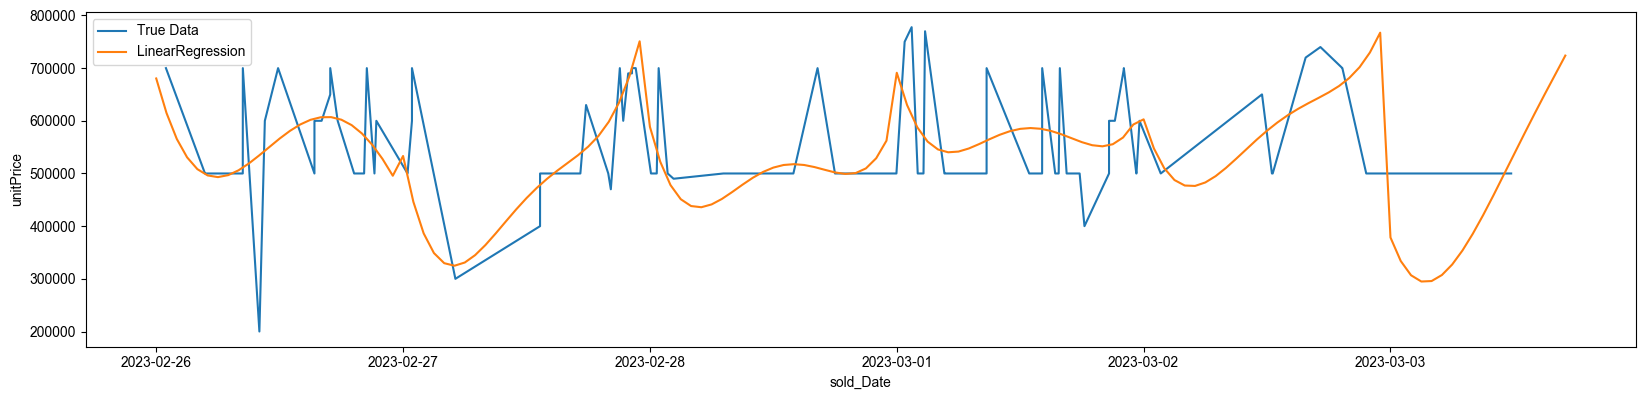

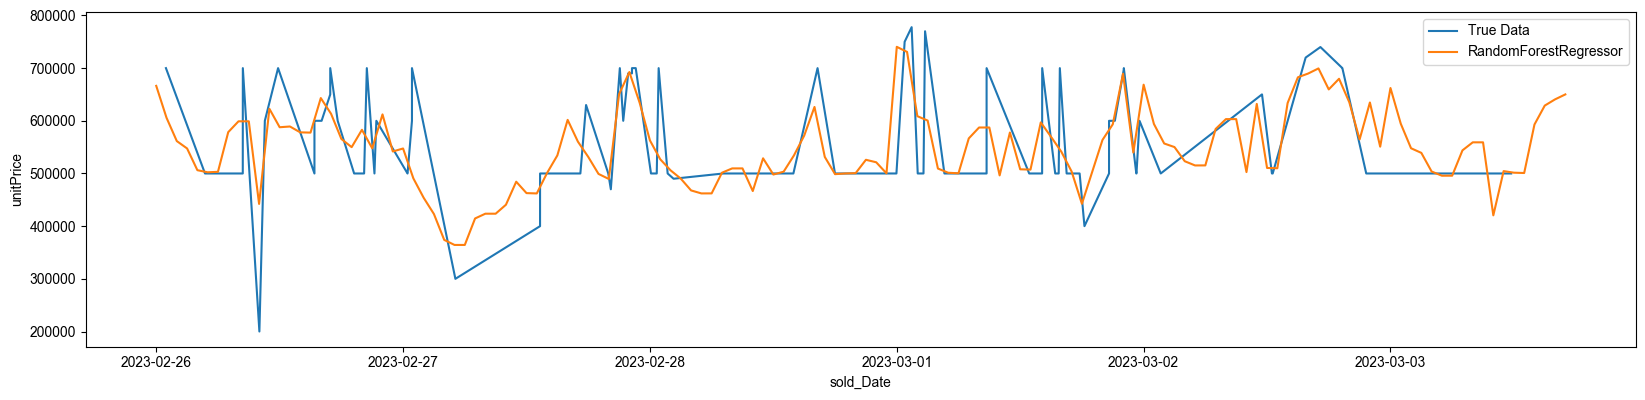

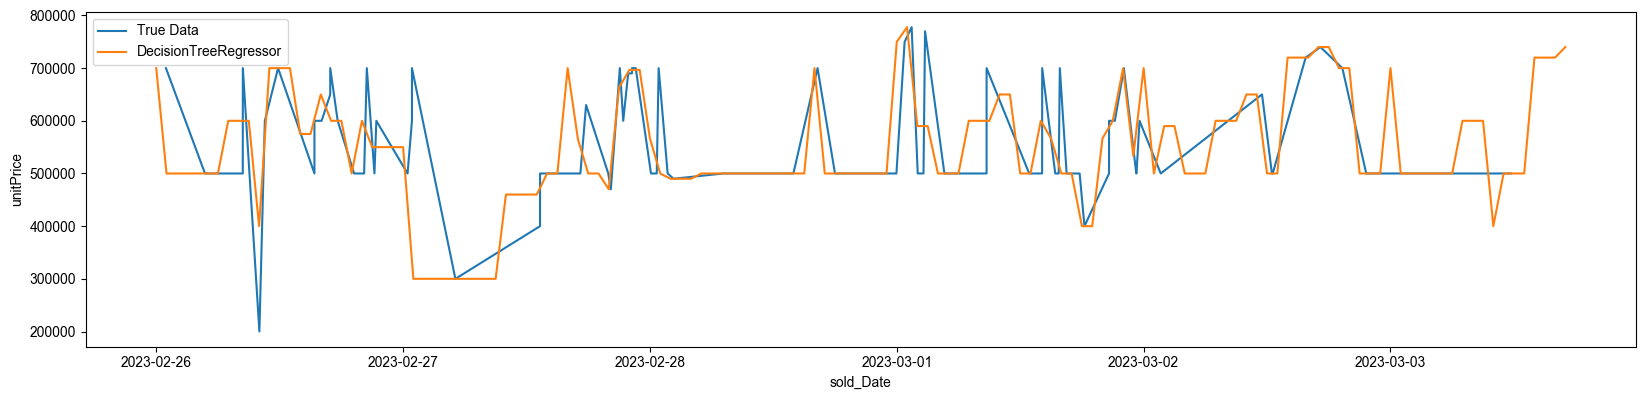

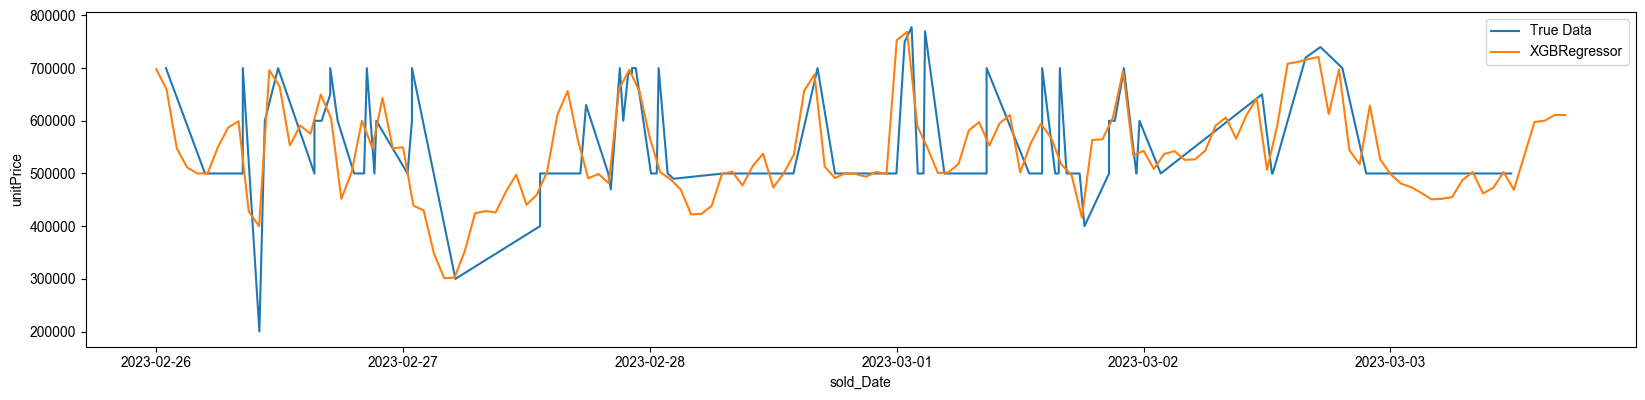

In [ ]:
dfs = [lm_df, rf_df, dt_df, xgb_df]
label = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'XGBRegressor']
for idx, m_df in enumerate(dfs):
    plt.figure(figsize=(20,20))
    plt.subplot(4, 1, idx+1)
    sns.lineplot(data = predict_price[predict_price['name_1']==1], x = 'sold_Date', y = 'unitPrice', label='True Data')
    sns.lineplot(data = m_df, x = 'sold_Date', y = 'pred', label=label[idx])
    # plt.xlim([np.datetime64('2023-03-01'), np.datetime64('2023-03-03')])
plt.show()